In [69]:
!pip install chembl_webresource_client --quiet

In [70]:
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
import pandas as pd
import math
import numpy as np

In [71]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [72]:
uniprot_id = "P14780"
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Matrix metalloproteinase 9,CHEMBL321,SINGLE PROTEIN
1,Homo sapiens,Matrix metalloproteinase 9,CHEMBL321,SINGLE PROTEIN
2,Homo sapiens,Collagenase,CHEMBL2095216,PROTEIN FAMILY
3,Homo sapiens,Matrix metalloproteinase 2/9,CHEMBL3885505,PROTEIN FAMILY
4,Homo sapiens,MMP-2/MMP-9,CHEMBL4523972,SELECTIVITY GROUP


In [73]:
target = targets.iloc[0]
chembl_id = target.target_chembl_id
target

,0
organism,Homo sapiens
pref_name,Matrix metalloproteinase 9
target_chembl_id,CHEMBL321
target_type,SINGLE PROTEIN


In [74]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

In [75]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2318, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50,nM,34.0
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50,nM,9.0
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50,nM,20.0
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50,nM,3.0
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50,nM,9.0


## Data Processing and Filtration

In [76]:
bioactivities_df["units"].unique()

array(['nM', 'uM', 'ug ml-1'], dtype=object)

In [77]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [78]:
# Convert 'standard_value' column to float
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})

# Drop rows with any missing values
bioactivities_df.dropna(axis=0, how="any", inplace=True)

# Filter rows where units are 'nM'
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]

# Drop duplicate entries based on 'molecule_chembl_id'
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)

# Reset index
bioactivities_df.reset_index(drop=True, inplace=True)

# Rename columns
bioactivities_df.rename(columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True)

# Display the final DataFrame shape and first few rows
print(f"Final DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

Final DataFrame shape: (2049, 11)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [79]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(tqdm(compounds_provider))

  0%|          | 0/2049 [00:00<?, ?it/s]

In [80]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (2049, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL2,{'canonical_smiles': 'COc1cc2nc(N3CCN(C(=O)c4c...
1,CHEMBL268377,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CN(C(...
2,CHEMBL7108,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CN(C(...
3,CHEMBL267939,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CCN(C...
4,CHEMBL415482,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CCN(C...


In [81]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.reset_index(drop=True, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2049, 2)
DataFrame shape: (2049, 2)
DataFrame shape: (2049, 2)


In [82]:
compounds_df.iloc[0].molecule_structures.keys()
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2049, 2)
DataFrame shape: (2049, 2)


In [83]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 2049


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [84]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 2049


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [85]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 2049 entries.


In [86]:
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [87]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL80814,34.0,nM,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...
1,CHEMBL276119,9.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...
2,CHEMBL78934,20.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...
3,CHEMBL78369,3.0,nM,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...
4,CHEMBL514138,9.0,nM,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...
5,CHEMBL80453,44.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CCCOc3ccccc3)C...
6,CHEMBL312432,6.0,nM,Cc1ccc(CN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OCc4ccc(...
7,CHEMBL306617,5.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CCOc3ccccc3...
8,CHEMBL79111,43.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CC)CC2)cc1
9,CHEMBL78798,2.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(OCCN...


In [88]:
#Verify that only nM units are present
bioactivities_df["units"].unique()

array(['nM'], dtype=object)

In [89]:
def convert_ic50_to_pic50(IC50_value):
    """
    Converts IC50 values to pIC50.
    Handles cases where IC50 values are <= 0 or NaN by returning NaN.
    """
    try:
        if IC50_value > 0:
            return 9 - math.log10(IC50_value)
        else:
            return np.nan  # Return NaN for invalid IC50 values
    except Exception as e:
        return np.nan  # Handle any unexpected errors gracefully


In [90]:
# Apply the conversion function to the DataFrame
output_df["pIC50"] = output_df["IC50"].apply(convert_ic50_to_pic50)

# Check for NaN values in the resulting column
print(f"Number of NaN pIC50 values: {output_df['pIC50'].isna().sum()}")

# Optionally, drop rows with NaN pIC50 values
output_df.dropna(subset=["pIC50"], inplace=True)

Number of NaN pIC50 values: 1


In [91]:
output_df.head()


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL80814,34.0,nM,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,7.468521
1,CHEMBL276119,9.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,8.045757
2,CHEMBL78934,20.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,7.698970
3,CHEMBL78369,3.0,nM,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,8.522879
4,CHEMBL514138,9.0,nM,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,8.045757


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

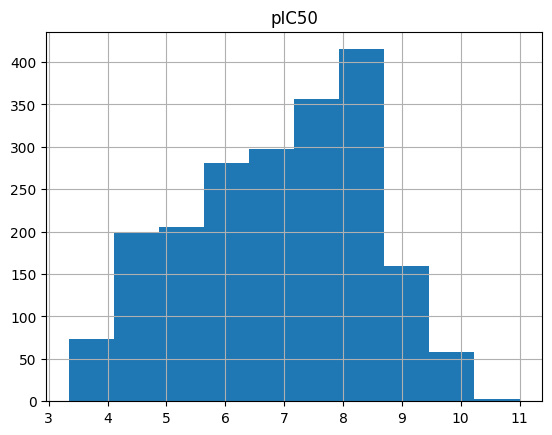

In [92]:
output_df.hist(column="pIC50")

In [93]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

# Drop the 'units' column
output_df.drop("units", axis=1, inplace=True)

# Display the updated DataFrame
output_df.head()

,molecule_chembl_id,IC50,smiles,pIC50
0,CHEMBL323090,0.01,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000
1,CHEMBL2064547,0.03,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879
2,CHEMBL2064549,0.05,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCF)nn2)[C@@...,10.301030
3,CHEMBL2064548,0.06,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCOS(=O)(=O)...,10.221849
4,CHEMBL2425941,0.07,CC(C)[C@H](C(=O)NO)N(CC#N)S(=O)(=O)c1ccc(OCCF)cc1,10.154902


In [94]:
print(f"DataFrame shape: {output_df.shape}")
output_df.to_csv("/content/sample_data/active_compounds.csv")

DataFrame shape: (2048, 4)
